# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [1]:
%matplotlib qt

QSocketNotifier: Can only be used with threads started with QThread


In [1]:
import logging
logging.basicConfig(level=logging.INFO, format=' - %(levelname)s - %(message)s')

In [2]:
from more_itertools import factor
import poppy
import xupy as xp
from xupy import typing as xt
import astropy.units as u
from astropy.table import QTable
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy import convolution as c
from opticalib import load_fits
from poppy.utils import rebin_array

Gpb = QTable.read("data/gaiaDR3passband.fits")
weights = Gpb.filled(0)

def rebinned(psf: fits.HDUList | xt.ArrayLike, rebin_factor: int) -> fits.HDUList:
    if isinstance(psf, fits.HDUList):
        psf = psf[0].data
    px_ratio = (rebin_factor, 3*rebin_factor)
    return rebin_array(psf, px_ratio)

 - INFO - Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
 - INFO - Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
 - INFO - NumExpr defaulting to 16 threads.
/home/pietrof/miniconda3/lib/python3.13/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')




[XuPy] Multiple GPUs detected:
       - gpu_id 0 : NVIDIA L40S | Memory = 45487.75 MB | Compute Capability = 8.9
       - gpu_id 1 : NVIDIA L40S | Memory = 45487.75 MB | Compute Capability = 8.9
       Using CuPy 13.4.1 for acceleration.


In [3]:
poppy.conf.use_multiprocessing = False
poppy.conf.n_processes = 20
poppy.conf.double_precision = False

M1 = poppy.RectangleAperture(name="Primary Mirror", width=1.45*u.m, height=0.5*u.m)
M2 = poppy.RectangleAperture(name="Beam Collimator / Secondary Mirror",width=0.35*u.m, height=0.2*u.m)

In [15]:
telescope = poppy.OpticalSystem(name="Gaia", oversample=1, verbose=True)

telescope.add_pupil(M1)
telescope.add_detector(name="SkyPLANE", pixelscale=0.001*(u.arcsec/u.pixel), fov_arcsec=1*u.arcsec, oversample=10)

psf = telescope.calc_psf(progressbar=True, return_final=True, source={'wavelengths': Gpb['lambda'], 'weights': weights['G']})

 - INFO - Initialized OpticalSystem: Gaia
 - INFO - Added pupil plane: Primary Mirror
 - INFO - Added detector with pixelscale=0.001 arcsec / pix and oversampling=10: SkyPLANE
 - INFO - Calculating PSF with 781 wavelengths
  0%|                                                   | 0/781 [00:00<?, ?it/s] - INFO -  Propagating wavelength = 320 nm
 - INFO - You did not define npix either on the OpticalSystem or its first optic; defaulting to 1024 pixels.
  0%|                                           | 1/781 [00:00<02:08,  6.06it/s] - INFO -  Propagating wavelength = 321 nm
 - INFO - You did not define npix either on the OpticalSystem or its first optic; defaulting to 1024 pixels.
  0%|                                           | 2/781 [00:00<02:07,  6.12it/s] - INFO -  Propagating wavelength = 322 nm
 - INFO - You did not define npix either on the OpticalSystem or its first optic; defaulting to 1024 pixels.
  0%|▏                                          | 3/781 [00:00<02:05,  6.20it/s] 

In [16]:
psf[0].writeto("data/gaia_psf_2.fits", overwrite=True)

In [17]:
ccd_psf = rebinned(psf[0], rebin_factor=59)

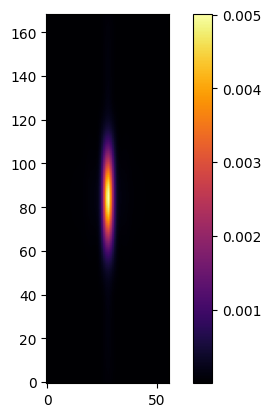

In [18]:
plt.imshow(ccd_psf, origin='lower', cmap='inferno')
plt.colorbar()

In [21]:
from simulator import GaiaTelescopeV0

gaia = GaiaTelescopeV0()
gaia.binary_map(5,5,200, (10*4500)*(30*1965))

 - INFO - Initialized OpticalSystem: unnamed system
 - INFO - Added pupil plane: Rectangle, size= 1.5 m wide * 0.5 m high
 - INFO - Added detector with pixelscale=0.059 arcsec / pix and oversampling=2: Detector
 - INFO - Calculating PSF with 1 wavelengths
 - INFO -  Propagating wavelength = 5.5e-07 m
 - INFO - You did not define npix either on the OpticalSystem or its first optic; defaulting to 1024 pixels.
 - INFO -   Calculation completed in 0.008 s
 - INFO - PSF Calculation completed.


TypeError: Unsupported type <class 'numpy.ndarray'>

In [34]:
ccd = poppy.OpticalSystem(name="CCD", oversample=4, verbose=True)
ccd.add_pupil(M1)
ccd.add_detector(name="CCD", pixelscale=0.059*(u.arcsec/u.pixel), fov_arcsec=6*u.arcsec, oversample=59)
ccd.add_rotation(90)

psf_ccd = ccd.calc_psf(progressbar=True, return_final=True, source={'wavelengths': Gpb['lambda'], 'weights': weights['G']})
ccd_psf = psf_ccd[0][0].data
ccd_psf = poppy.utils.rebin_array(ccd_psf, (1,3))

plt.figure(figsize=(8,8))
plt.imshow(ccd_psf, origin='lower', cmap='inferno')
plt.colorbar(shrink=0.8, label='Intensity')
plt.title("CCD PSF")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

  0%|                                                   | 0/781 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 781/781 [01:07<00:00, 11.58it/s]
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [35]:
poppy.display_psf(psf_ccd[0], title='PSF on CCD')

# Prova